WIP : transform and clean feature columns

In [1]:
import os
import pandas as pd
from pandas import json_normalize
from pathlib import Path
import datetime
from datetime import datetime as dt
import numpy as np
import json
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings
#warnings.filterwarnings("ignore")

%matplotlib inline
#plt.rcParams['figure.figsize'] = (18, 8)

##### Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
# read data
logins = pd.read_json(Path.cwd().joinpath('ultimate_challenge/logins.json'))

In [3]:
print(logins.head(), '\n')
print(logins.describe(), '\n')
logins.info()

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21 

                 login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
# make a count column as a requency holder before setting login_time as the index
logins['count'] = 1
logins.tail()

,login_time,count
93137,1970-04-13 18:50:19,1
93138,1970-04-13 18:43:56,1
93139,1970-04-13 18:54:02,1
93140,1970-04-13 18:57:38,1
93141,1970-04-13 18:54:23,1


In [5]:
logins = logins.set_index('login_time')
logins.tail()

,count
login_time,
1970-04-13 18:50:19,1
1970-04-13 18:43:56,1
1970-04-13 18:54:02,1
1970-04-13 18:57:38,1
1970-04-13 18:54:23,1


In [6]:
logincount_df = logins.resample('15Min').sum()

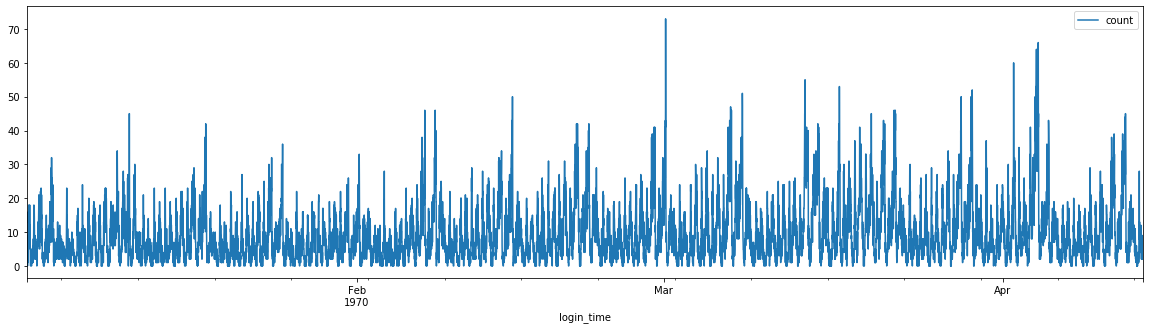

In [7]:
logincount_df.plot(figsize=(20,5))

From the above graph we can see there are some cyclic patterns on a daily and weekly levels. 
Let's look at logins over 6hrs for the first few weeks.

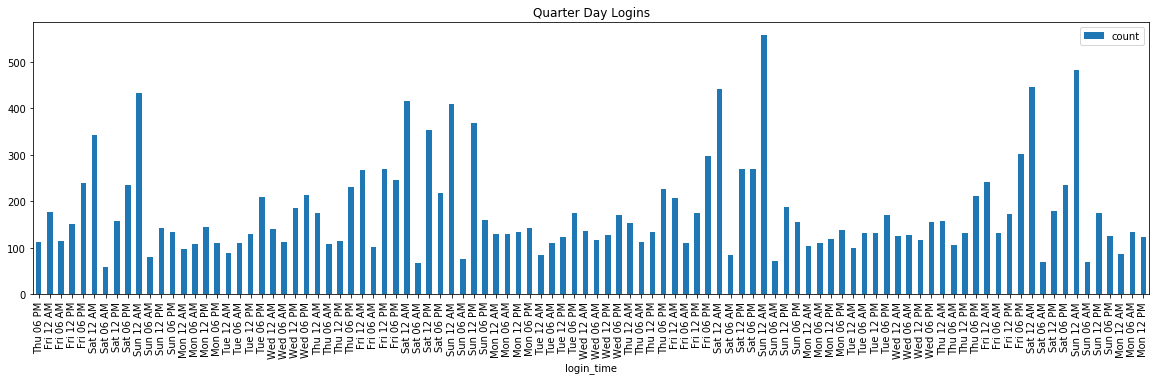

In [8]:
quatday_df = logins.resample('6H').sum()[:100]
quatday_df = quatday_df.set_index(quatday_df.index.strftime('%a %I %p'))
quatday_df.plot(figsize=(20,5), kind='bar', title='Quarter Day Logins')

Spikes in weekend logins are clear. But, we can also see that most spikes on weekdays are during daytime and on weekend at late night. Now, let's see whether there are any significant patterns in days

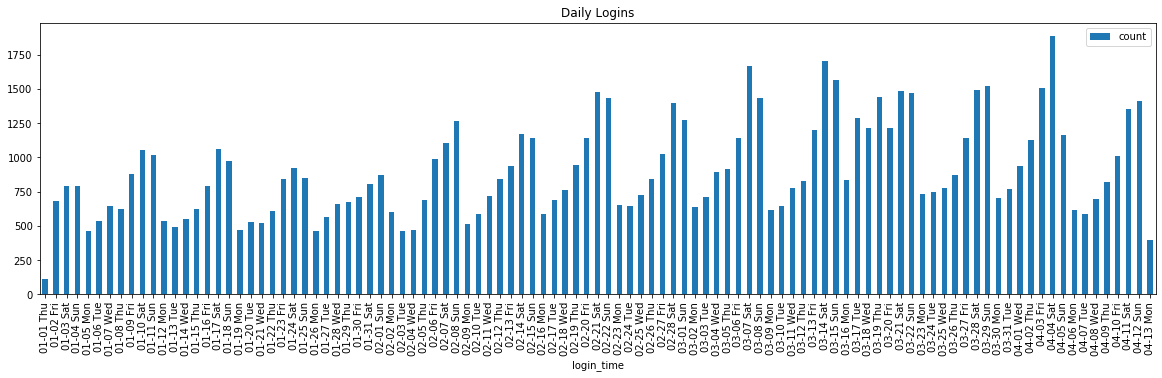

In [9]:
day_df = logins.resample('D').sum()
day_df = day_df.set_index(day_df.index.strftime('%m-%d %a'))
day_df.plot( figsize=(20,5), kind='bar', title='Daily Logins')

We can see an upward trend from Monday thorugh the week, with Saturday peaking in most weeks.

Now, for some seasonal pattern, let's make it less granular and group over weeks.

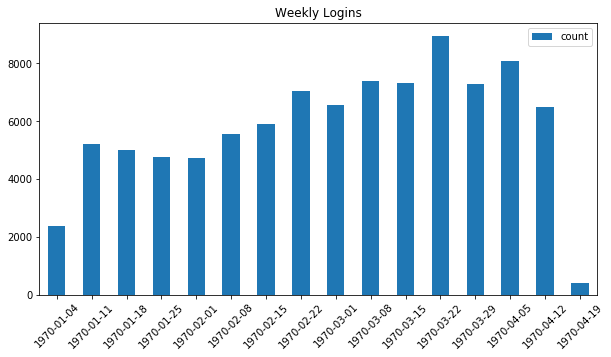

In [10]:
week_df = logins.resample('W').sum()
week_df = week_df.set_index(week_df.index.date)
week_df.plot( figsize=(10,5), kind='bar', rot=45, title='Weekly Logins')

There is a general upward trend from winter, with a peak in the week spring officially arrives.

##### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

Answer:

1. Assuming we have access to user logins and information on destination or origin cities, we can design an experiment which counts how many times the bridge was crossed before and after Ultimate began reimbursing toll costs for a set period time. The metric would use is number of bridge crossings over a period of time, because it should directly measure willingness of drivers from both cities to be available in either cities.

2. Given the cities are active throughout the weekend, but have complementary circadian rhythm on weekdays, number of bridge crossings may not be affected on weekends. However, on weekdays drivers in one city may be available more during the busy periods of the other city. If the toll cost is suppose to be the main issue causing drivers to be exclusive, then the following experiment should provide evidence for it.

> Let $\mu_{0}$ and $\mu_{1}$ be the mean number of users crossing the bridge on weekdays over a fixed number of weeks, from Gotham to Metropolis during the day and from Metropolis to Gotham during the night, before and after the reimbursement policy respectively.
Conduct a t-test to test the hypothesis:

 > $H_{0}$ :  $\mu_{0} = \mu_{1}$
 
 > $H_{1}$ :  $\mu_{0} < \mu_{1}$

In [11]:
users = pd.read_json(Path.cwd().joinpath('ultimate_challenge/ultimate_data_challenge.json'))
users.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [12]:
users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


##### Impute missing values

In [14]:
# get null values
users[users.isna().any(axis=1)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0


Let us first focus on null values in the rating columns

In [15]:
mis_rating = users[users.isna().any(axis=1)][['avg_rating_of_driver', 'avg_rating_by_driver']]

We will impute ratings 'of' and 'by' driver by -
  - if atleast one of the two ratings are present, we impute one with the other, assuming it was most probable that both the driver and the rider had similar experiences.
  - if both are missing, apply means(floored) for each column respectively.

In [16]:
avg_of = int(users['avg_rating_of_driver'].mean())
avg_by = int(users['avg_rating_by_driver'].mean())

for row, val in mis_rating.iterrows():
    
    if np.isnan(val[0]):
        if not np.isnan(val[1]):
            users['avg_rating_of_driver'][row] = users['avg_rating_by_driver'][row]
        else:
            users['avg_rating_of_driver'][row] = avg_of
            
    if np.isnan(val[1]):
        if not np.isnan(val[0]):
            users['avg_rating_by_driver'][row] = users['avg_rating_of_driver'][row]
        else:
            users['avg_rating_by_driver'][row] = avg_by

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Administ

The remaining nulls are in the phone column. Let us impute those with the most occuring phone value.

In [17]:
android = users.phone[users.phone == "Android"].count()
iphone = users.phone[users.phone == "iPhone"].count()
print('There are {} androids and {} iphones'.format(android, iphone))
users.phone[users.isna().any(axis=1)] = 'iPhone'

There are 15022 androids and 34582 iphones


C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Double check for any nulls

In [18]:
users.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

##### Transform and cast columns to correct data type
Given columns 'city' and 'phone' are categorical, we should encode them.

In [19]:
# encode phone column
phone_enc = LabelEncoder().fit(users.phone)
users.phone = phone_enc.transform(users.phone)

# encode city column
city_enc = LabelEncoder().fit(users.city)
users.city = city_enc.transform(users.city)

Now let's cast columns 'signup_date' and 'last_trip_date' to datetime

In [20]:
users = users.astype({'signup_date' :'datetime64[D]', 'last_trip_date': 'datetime64[D]'})

##### Create labels for retained users

In [21]:
# get date of beginning 'active' period
active_start = users.last_trip_date.max() - pd.Timedelta('30 days')

In [22]:
# create retained label by marking user as active if their last trip was after active_start
users['retained'] = (users.last_trip_date > active_start).astype('int')

In [23]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,1,4,2014-01-25,4.7,1.10,2014-06-17,1,15.4,True,46.2,3.67,5.0,1
1,0,0,2014-01-29,5.0,1.00,2014-05-05,0,0.0,False,50.0,8.26,5.0,0
2,0,3,2014-01-06,4.3,1.00,2014-01-07,1,0.0,False,100.0,0.77,5.0,0
3,1,9,2014-01-10,4.6,1.14,2014-06-29,1,20.0,True,80.0,2.36,4.9,1
4,2,14,2014-01-27,4.4,1.19,2014-03-15,0,11.8,False,82.4,3.13,4.9,0


In [24]:
# Get fraction of retained users
retained = users.retained.sum()
fraction = round((retained/len(users)) * 100, 2)
print('{} percent of users were retained.'.format(fraction))

36.62 percent of users were retained.


#### Create a random forest model

In [ ]:
data_x = users.drop(['retained'], axis=1)
data_y = users['retained']
data_x.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( \
        data_x, data_y, test_size=0.25, stratify=data_y, random_state=17)

In [ ]:
rfc = RandomForestClassifier(random_state=17, class_weight='balanced_subsample')

hpar = { 'n_estimators' : [50, 100, 150, 200], 'criterion' : ['gini', 'entropy'], 
         'max_features' : [None, 0.3, 0.5, 0.7], 'max_samples': [0.6, 0.8, 1],
         'max_depth' : [5, 10, 15, 20]}

rfc_cv = GridSearchCV(rfc , param_grid = hpar , cv = 5)
rfc_cv.fit(X_train, y_train)

print(rfc_cv.best_params_)

In [ ]:
print(' Accuracy on training data : \n' , classification_report(y_train, rfc_cv.predict(X_train), target_names=['non-adopted', 'adopted']))
print(' Accuracy on test data : \n' , classification_report(y_test, rfc_cv.predict(X_test), target_names=['non-adopted', 'adopted']))